In [1]:
from plyfile import PlyData, PlyElement

import math
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
plt.rcParams['legend.fontsize'] = 2
plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
max_sh_degree = 3

In [30]:
root = "/home/loyot/workspace/code/gaussian-splatting/output_back/coffee_martini_dy_v2/0/point_cloud/iteration_10000/point_cloud.ply"
xyz_0 = load_ply(root)
root = "/home/loyot/workspace/code/gaussian-splatting/output_back/coffee_martini_dy_v2/1/point_cloud/iteration_2000/point_cloud.ply"
xyz_1 = load_ply(root)
print(xyz_0.shape)
print(xyz_1.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/home/loyot/workspace/code/gaussian-splatting/output_back/coffee_martini_dy_v2/0/point_cloud/iteration_10000/point_cloud.ply'

In [2]:
# read ply file
import glob
root = "/home/loyot/workspace/code/gaussian-splatting/output_back/coffee_martini/*/point_cloud/iteration_2000/*.ply"
ply_list = glob.glob(root)

import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

ply_list.sort(key=natural_keys)

In [3]:
def load_ply(path):
    plydata = PlyData.read(path)

    xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                    np.asarray(plydata.elements[0]["y"]),
                    np.asarray(plydata.elements[0]["z"])),  axis=1)
    
    rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
    rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
    rots = np.zeros((xyz.shape[0], len(rot_names)))
    for idx, attr_name in enumerate(rot_names):
        rots[:, idx] = np.asarray(plydata.elements[0][attr_name])
        
    return xyz, rots

In [25]:
import tqdm

In [4]:
import tqdm
xyzs_list = []
rots_list = []
for i in tqdm.tqdm(range(len(ply_list))):
    xyz_i, rot_i = load_ply(ply_list[i])
    xyzs_list.append(xyz_i)
    rots_list.append(rot_i)

100%|██████████| 299/299 [00:52<00:00,  5.68it/s]


In [5]:
xyzs_list_numpy = np.stack(xyzs_list)
rots_list_numpy = np.stack(rots_list)
xyzs_list_torch = torch.from_numpy(xyzs_list_numpy)
rots_list_torch = torch.from_numpy(rots_list_numpy)
xyzs_dist = xyzs_list_torch - xyzs_list_torch.mean(dim=0, keepdim=True)
sorted, indice = torch.sort(torch.abs(xyzs_dist).sum(0).sum(-1))

In [7]:
Hz_base = (3/16)*np.pi
class Fitting_fft(torch.nn.Module):
    def __init__(self, dim):

        super(Fitting_fft,self).__init__()
        self.param = torch.nn.Parameter(torch.randn((dim, 2)))


    def forward(self, x):

        y = 0.
        for i in range(self.param.size(0)):
            y += (self.param[i, 0] * torch.sin(i*Hz_base*x) + self.param[i, 1] * torch.cos(i*Hz_base*x))

        return y

class Fitting_polynomial(torch.nn.Module):
    def __init__(self, dim):

        super(Fitting_polynomial,self).__init__()
        self.param = torch.nn.Parameter(torch.randn((dim, )))


    def forward(self, x):

        y = 0.
        for i in range(self.param.size(0)):
            y += self.param[i] * x ** i

        return y

SyntaxError: invalid syntax (3915590825.py, line 1)

In [18]:
def get_dim_model(y_target, x, dim=9, model_func=Fitting_polynomial):
    # Create Tensors to hold input and outputs.
    y = torch.from_numpy(y_target)

    # Construct our model by instantiating the class defined above
    model = model_func(dim)

    criterion = torch.nn.SmoothL1Loss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    for t in tqdm.tqdm(range(100000)):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y)
        # if t % 2000 == 1999:
        #     print("epoch:{},mse:{}".format(t+1, loss.item()))
        #     print(f'Result: {model.string()}')
        #     plt.plot(x,y,label="raw")
        #     plt.legend()
        #     model.plot_poly(x)
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

In [9]:
# test fitting 
point_id = indice[-1]
x = torch.linspace(0, 1, 299)
x_target = xyzs_list_numpy[:, point_id, 0]
y_target = xyzs_list_numpy[:, point_id, 1]
z_target = xyzs_list_numpy[:, point_id, 2]

x_model = get_dim_model(x_target, x)
y_model = get_dim_model(y_target, x)
z_model = get_dim_model(z_target, x)

100%|██████████| 100000/100000 [00:18<00:00, 5295.19it/s]


In [21]:
# test fitting 
point_id = indice[-4]
x = torch.linspace(0, 1, 299)
x_target = rots_list_numpy[:, point_id, 0]
y_target = rots_list_numpy[:, point_id, 1]
z_target = rots_list_numpy[:, point_id, 2]
k_target = rots_list_numpy[:, point_id, 3]

x_model = get_dim_model(x_target, x, dim=18)
x_model_fft = get_dim_model(x_target, x, dim=9, model_func=Fitting_fft)
y_model = get_dim_model(y_target, x, dim=18)
y_model_fft = get_dim_model(y_target, x, dim=9, model_func=Fitting_fft)
z_model = get_dim_model(z_target, x, dim=18)
z_model_fft = get_dim_model(z_target, x, dim=9, model_func=Fitting_fft)
k_model = get_dim_model(k_target, x, dim=18)
k_model_fft = get_dim_model(k_target, x, dim=9, model_func=Fitting_fft)

100%|██████████| 100000/100000 [00:40<00:00, 2481.47it/s]


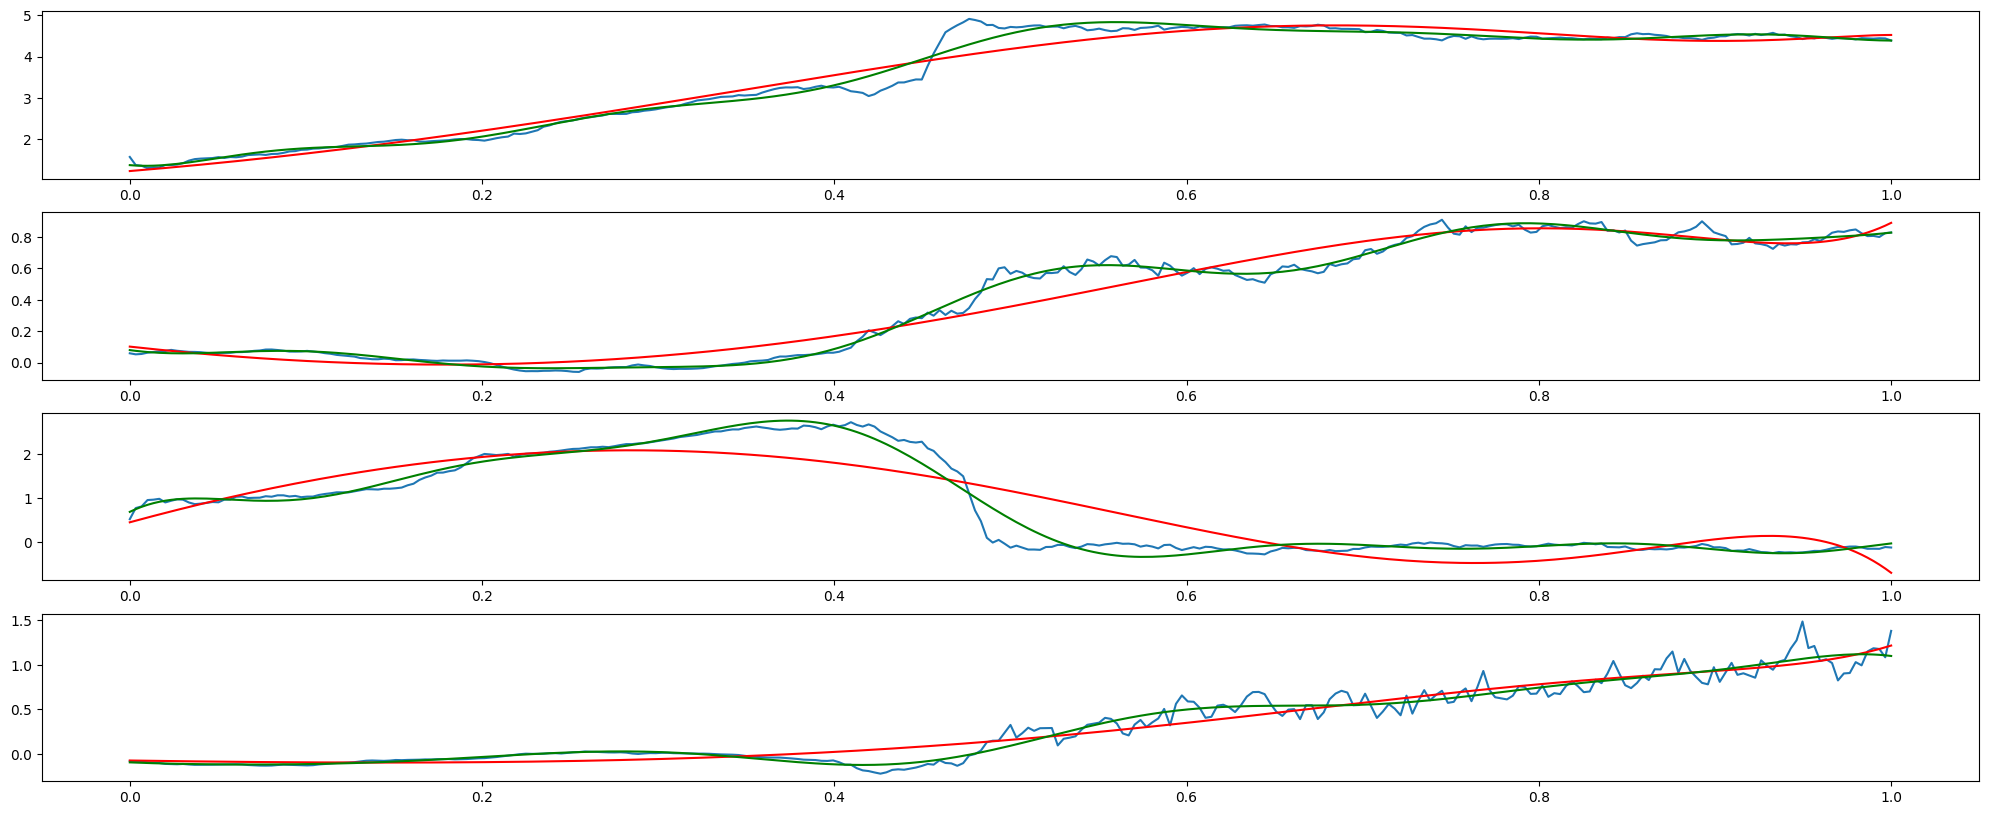

In [22]:
point_id = indice[-4]
fig, axs = plt.subplots(nrows=4, ncols=1)
axs[0].plot(x, rots_list_numpy[:, point_id, 0])
axs[0].plot(x, x_model(x).cpu().detach().numpy(), color='red')
axs[0].plot(x, x_model_fft(x).cpu().detach().numpy(), color='green')
axs[1].plot(x, rots_list_numpy[:, point_id, 1])
axs[1].plot(x, y_model(x).cpu().detach().numpy(), color='red')
axs[1].plot(x, y_model_fft(x).cpu().detach().numpy(), color='green')
axs[2].plot(x, rots_list_numpy[:, point_id, 2])
axs[2].plot(x, z_model(x).cpu().detach().numpy(), color='red')
axs[2].plot(x, z_model_fft(x).cpu().detach().numpy(), color='green')
axs[3].plot(x, rots_list_numpy[:, point_id, 3])
axs[3].plot(x, k_model(x).cpu().detach().numpy(), color='red')
axs[3].plot(x, k_model_fft(x).cpu().detach().numpy(), color='green')
plt.show()

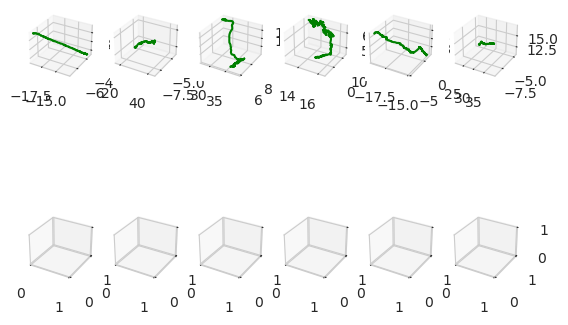

In [35]:
num_curve = 6
fig, axs = plt.subplots(nrows=2, ncols=num_curve, subplot_kw={'projection': '3d'})

# plot raw curve
for idx in range(1, num_curve+1):
    point_id = indice[-idx]
    x = xyzs_list_numpy[:, point_id, 0]
    y = xyzs_list_numpy[:, point_id, 1]
    z = xyzs_list_numpy[:, point_id, 2]
    axs[0, idx-1].plot(x, y, z, color='g')

plt.show()

training curve: 1


100%|██████████| 100000/100000 [00:18<00:00, 5348.76it/s]


training curve: 2


100%|██████████| 100000/100000 [00:18<00:00, 5377.08it/s]


training curve: 3


100%|██████████| 100000/100000 [00:18<00:00, 5370.41it/s]


training curve: 4


100%|██████████| 100000/100000 [00:18<00:00, 5333.48it/s]


training curve: 5


100%|██████████| 100000/100000 [00:18<00:00, 5373.69it/s]


training curve: 6


100%|██████████| 100000/100000 [00:18<00:00, 5354.99it/s]


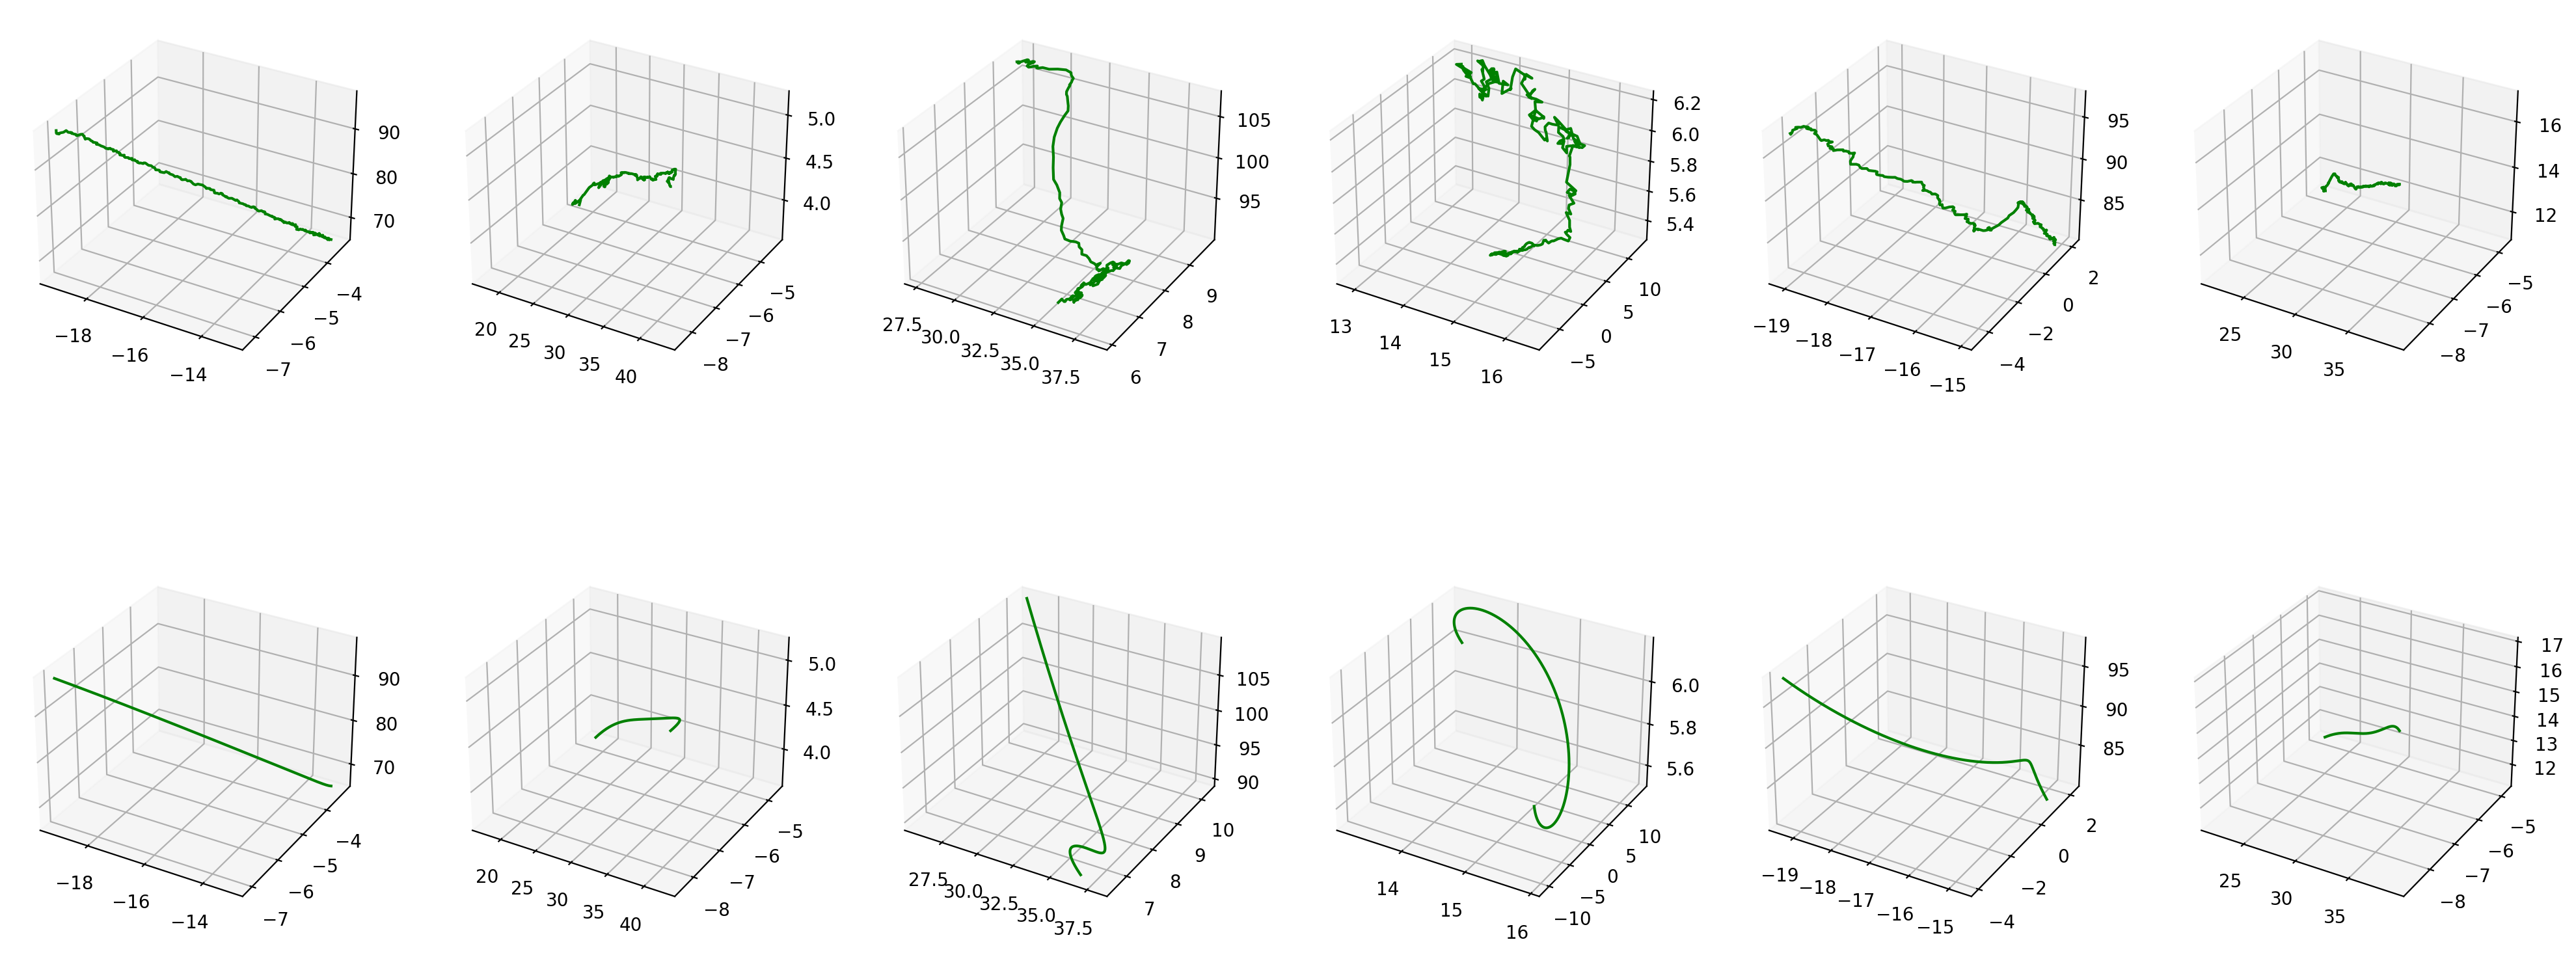

In [22]:
num_curve = 6
fig, axs = plt.subplots(nrows=2, ncols=num_curve, subplot_kw={'projection': '3d'})

# plot raw curve
for idx in range(1, num_curve+1):
    point_id = indice[-idx]
    x = xyzs_list_numpy[:, point_id, 0]
    y = xyzs_list_numpy[:, point_id, 1]
    z = xyzs_list_numpy[:, point_id, 2]
    axs[0, idx-1].plot(x, y, z, color='g')
    # axs[0, idx].set_title(f'raw curve {idx}')
    
# train polynomial to fit curve
for idx in range(1, num_curve+1):
    print(f"training curve: {idx}")
    point_id = indice[-idx]
    x = torch.linspace(0, 1, 299)
    x_target = xyzs_list_numpy[:, point_id, 0]
    y_target = xyzs_list_numpy[:, point_id, 1]
    z_target = xyzs_list_numpy[:, point_id, 2]

    x_model = get_dim_model(x_target, x)
    y_model = get_dim_model(y_target, x)
    z_model = get_dim_model(z_target, x)
    axs[1, idx-1].plot(
        x_model(x).cpu().detach().numpy(), 
        y_model(x).cpu().detach().numpy(), 
        z_model(x).cpu().detach().numpy(), 
        color='g'
    )
    # axs[1, idx].set_title(f'fitting curve {idx}')

plt.show()

In [11]:
import taichi as ti
ti.init(arch=ti.cuda, offline_cache=False)

@ti.kernel
def poly_kernel_fwd(factors: ti.types.ndarray(), t: ti.types.ndarray(), out: ti.types.ndarray()):
    for pid, dim_id, f_id in ti.ndrange(factors.shape[0], factors.shape[1], factors.shape[2]):
        out[pid, dim_id] += factors[pid, dim_id, f_id] * (t[pid] ** f_id)
        
@ti.kernel
def poly_kernel_bwd(d_factors: ti.types.ndarray(), t: ti.types.ndarray(), d_out: ti.types.ndarray()):
    for pid, dim_id, f_id in ti.ndrange(d_factors.shape[0], d_factors.shape[1], d_factors.shape[2]):
        d_factors[pid, dim_id, f_id] = d_out[pid, dim_id] * (t[pid] ** f_id)
        
class _polynomial_taichi(torch.autograd.Function):
    @staticmethod
    def forward(ctx, factors, t):
        ctx.save_for_backward(factors, t)
        out = torch.empty(
            (factors.shape[0], factors.shape[1]), 
            dtype=torch.float32, 
            device=factors.device
        )
        poly_kernel_fwd(factors, t, out)
        return out
    
    @staticmethod
    def backward(ctx, d_out):
        factors, t = ctx.saved_tensors
        d_factors = torch.empty_like(factors)
        poly_kernel_bwd(d_factors, t, d_out)
        return d_factors, None
    
from scene.taichi_modules.fft_poly_taichi import FFTPloy_taichi
from scene.taichi_modules.poly_taichi import Polynomial_taichi
from scene.taichi_modules.fft_taichi import FFT_taichi

        
class Fit_taichi(torch.nn.Module):
    def __init__(self, num_points, dim, max_degree, fit_type='poly'):
        super(Fit_taichi,self).__init__()
        self.dim = dim
        self.max_degree = max_degree
        if fit_type=='poly':
            vec_per_degree = 1
            self.kernel = Polynomial_taichi(max_degree)
        elif fit_type == 'fft':
            vec_per_degree = 2
            self.kernel = FFT_taichi(max_degree)
        elif fit_type == 'fftpoly':
            vec_per_degree = 3
            self.kernel = FFTPloy_taichi(max_degree)
        self.factors = torch.nn.Parameter(
            torch.randn(
                (num_points, max_degree, dim, vec_per_degree),
                dtype=torch.float32,
            ).requires_grad_(True)
        )
        
    def forward(self, t):
        return self.kernel(self.factors, t, self.max_degree)
    

[Taichi] Starting on arch=cuda


In [21]:
type(t_i[0].item())

float

In [38]:
t = torch.linspace(0, 1, 299)
xyz_target = torch.from_numpy(xyzs_list_numpy[:, indice[[-3, -4, -5, -14]], :])

In [39]:
Poly1 = Fit_taichi(4, 3, 8).cuda()
Poly2 = Fit_taichi(4, 3, 8, fit_type='fft').cuda()
Poly3 = Fit_taichi(4, 3, 8, fit_type='fftpoly').cuda()

In [40]:

Poly1 = Fit_taichi(4, 3, 8).cuda()
Poly2 = Fit_taichi(4, 3, 4, fit_type='fft').cuda()
Poly3 = Fit_taichi(4, 3, 8, fit_type='fftpoly').cuda()

criterion = torch.nn.SmoothL1Loss(reduction='mean')
optimizer = torch.optim.SGD(Poly1.parameters(), lr=1e-2, momentum=0.9)
        
progress_bar = tqdm.tqdm(range(30000), desc="Training Polynomial_taichi progress")
for b in range(30000):
    random_id = torch.randint(0, 299, ())
    t_i = t[random_id][None]
    y_target = xyz_target[random_id:random_id+1, :]
    y_pre = Poly1(t_i[0].item())
    loss = criterion(y_pre, y_target.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if b % 10 == 0:
        progress_bar.set_postfix({"loss": loss.item()})
        progress_bar.update(10)
progress_bar.close()

criterion = torch.nn.SmoothL1Loss(reduction='mean')
optimizer = torch.optim.SGD(Poly2.parameters(), lr=1e-2, momentum=0.9)
    

Training Polynomial_taichi progress: 100%|██████████| 30000/30000 [00:37<00:00, 792.23it/s, loss=2.34]  


In [41]:
progress_bar = tqdm.tqdm(range(30000), desc="Training FFT_taichi progress")
for b in range(30000):
    random_id = torch.randint(0, 299, ())
    t_i = t[random_id][None]
    y_target = xyz_target[random_id:random_id+1, :]
    y_pre = Poly2(t_i[0].item())
    loss = criterion(y_pre, y_target.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if b % 10 == 0:
        progress_bar.set_postfix({"loss": loss.item()})
        progress_bar.update(10)
progress_bar.close()


criterion = torch.nn.SmoothL1Loss(reduction='mean')
optimizer = torch.optim.SGD(Poly3.parameters(), lr=1e-2, momentum=0.9)
        
progress_bar = tqdm.tqdm(range(30000), desc="Training FFTPolytaichi progress")
for b in range(30000):
    random_id = torch.randint(0, 299, ())
    t_i = t[random_id][None]
    y_target = xyz_target[random_id:random_id+1, :]
    y_pre = Poly3(t_i[0].item())
    loss = criterion(y_pre, y_target.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if b % 10 == 0:
        progress_bar.set_postfix({"loss": loss.item()})
        progress_bar.update(10)
progress_bar.close()

Training FFTPolytaichi progress: 100%|██████████| 30000/30000 [00:20<00:00, 1453.10it/s, loss=0.00916] 


In [36]:
y_pre = Poly(torch.tensor([0.]))

In [37]:
y_pre

tensor([[-1.9565e+01, -7.0485e+00,  2.0789e+11]],
       grad_fn=<_polynomial_taichiBackward>)

In [38]:
xyz_target[0, :]

tensor([-19.2328,  -7.1422,  97.5744])

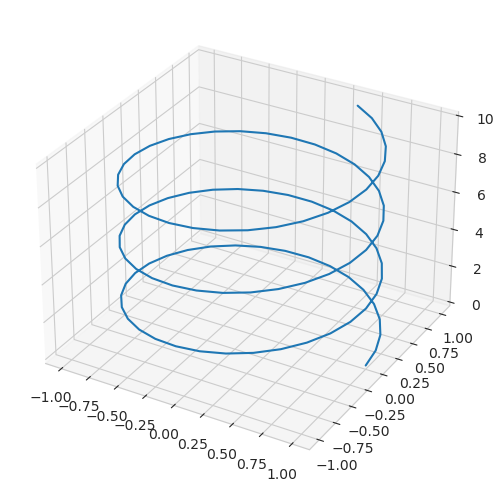

In [2]:
import seaborn as sb
import matplotlib.pyplot as plot
import numpy as np
sb.set_style("whitegrid")
plot_omega = 2
plot1 = np.linspace(0, 10, 100)
plot2 = np.cos(plot_omega * plot1)
plot3 = np.sin(plot_omega * plot1)
plot.figure(figsize=(6,5))
plot_axis = plot.axes (projection = '3d')
plot_axis.plot3D (plot2, plot3, plot1)
plot.tight_layout ()
plot.show ()

In [55]:
with torch.no_grad():
    time_input = np.linspace(0, 1, 300)
    Poly1_eval = []
    for t_i in time_input:
        Poly1_eval.append(
            Poly1(t_i).cpu().numpy()
        )
    Poly1_eval = np.stack(Poly1_eval)
    Poly2_eval = []
    for t_i in time_input:
        Poly2_eval.append(
            Poly2(t_i).cpu().numpy()
        )
    Poly2_eval = np.stack(Poly2_eval)
        
    Poly3_eval = []
    for t_i in time_input:
        Poly3_eval.append(
            Poly3(t_i).cpu().numpy()
        )
    Poly3_eval = np.stack(Poly3_eval)

In [61]:
Poly2_eval.shape

(300, 4, 3)

NameError: name 'Poly1_eval' is not defined

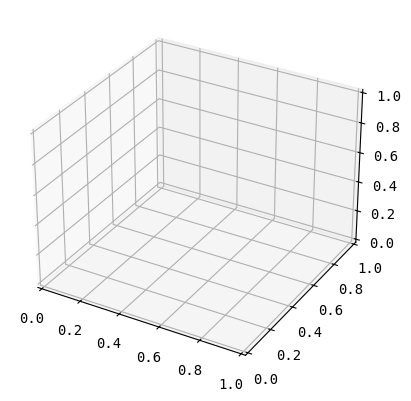

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl  
mpl.rc('font',family='monospace')

fig = plt.figure()
ax = plt.axes(projection='3d')

idx = 1
idxs = [-3, -4, -5, -14]
line_wdith = 4
predata = Poly1_eval
zline = predata[:, idx, 2]
xline = predata[:, idx, 0]
yline = predata[:, idx, 1]
ax.plot3D(xline, yline, zline, 'green', label='Poly', linewidth=line_wdith)

predata = Poly2_eval
zline = predata[:, idx, 2]
xline = predata[:, idx, 0]
yline = predata[:, idx, 1]
ax.plot3D(xline, yline, zline, 'yellow', label='Fourier', linewidth=line_wdith)

predata = Poly3_eval
zline = predata[:, idx, 2]
xline = predata[:, idx, 0]
yline = predata[:, idx, 1]
ax.plot3D(xline, yline, zline, 'red', label='DDDM', linewidth=line_wdith)

point_id = indice[idxs[idx]]
xdata = xyzs_list_numpy[::5, point_id, 0]
ydata = xyzs_list_numpy[::5, point_id, 1]
zdata = xyzs_list_numpy[::5, point_id, 2]

ax.scatter3D(xdata, ydata, zdata, cmap='Blues', label='Samples', linewidth=line_wdith)
ax.set_zticks([])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.legend().remove()
# plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.legend(fontsize="15")
plt.show()

In [10]:
len(xdata)

299